In [ ]:
# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving archive.zip to archive.zip
User uploaded file "archive.zip" with length 63252113 bytes


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
!ls

drive  sample_data


In [ ]:
# !rm -rf major

In [ ]:
# %cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
# ! pip install -q kaggle

In [ ]:
# import os
# os.environ['username'] = 'rekhalodhi' # username from the json file
# os.environ['key'] = 'b3a5d08ff70b9f6c085a23d12bc9b1a0' # key from the json file

In [ ]:
# !mv archive.zip /content/drive/MyDrive/EBMRS

In [ ]:
# !mv .kaggle /root/              #move file to te root directory

In [ ]:
# https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=fer2013.tar.gz
#----------------- https://www.kaggle.com/msambare/fer2013

In [ ]:
# !kaggle datasets download -d deadskull7/fer2013

In [ ]:
# !unzip '/content/drive/MyDrive/EBMRS/archive.zip' -d '/content/drive/MyDrive/EBMRS/tt_data'

In [2]:
%cd /content/drive/MyDrive/EBMRS

/content/drive/MyDrive/EBMRS


In [ ]:
pwd

'/content/drive/My Drive/EBMRS'

In [ ]:
!ls

archive.zip  emotion.ipynb  emotio_rec	tt_data


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

(48, 48, 3)
(1, 48, 48, 3)


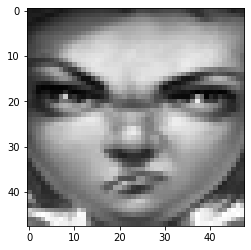

In [4]:
from keras.preprocessing import image
img = image.load_img('tt_data/train/angry/Training_37417413.jpg',target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

# DATA AUGMENTATION

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=5,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,        #zoom in the range [1-zoom_range,1+zoom_range]
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = 'tt_data/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   color_mode = 'grayscale',
                                                   shuffle = True,
                                                   batch_size = 64)

In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'tt_data/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  color_mode = 'grayscale',
                                                  batch_size = 64, 
                                                  shuffle = True)

In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = 'tt_data/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  color_mode = 'grayscale',
                                                  batch_size = 64, 
                                                  shuffle = True)

Found 7178 images belonging to 7 classes.


In [ ]:
# base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

# Convolution neural network

In [ ]:
'''install the keras-tuner for neural network hyperparameter tuning'''

!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 8.3MB/s 


In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D

In [ ]:
from kerastuner.tuners import Hyperband, RandomSearch

In [ ]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5,11]),
        kernel_initializer='he_normal',
        activation='relu',
        input_shape=(48,48,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        kernel_initializer='he_normal',
        activation='relu'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        kernel_initializer='he_normal',
        activation='relu'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=64, max_value=256, step=16),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        kernel_initializer='he_normal',
        activation='relu'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(7, activation='softmax')
  ])
  # print()
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
# def build_model(hp):
#     cnn = tf.keras.models.Sequential()
#     # Convolution 
#     cnn.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
#                 kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
#                 activation='relu',
#                 input_shape=(48,48,1)))
#     cnn.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=8),
#                 kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),activation='relu'))
#     # pooling
#     cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
#     # Convolution
#     cnn.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
#                                    kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),activation='relu'))
#     cnn.add(tf.keras.layers.Conv2D(filters=hp.Int('conv_4_filter', min_value=32, max_value=64, step=8),
#                                    kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),activation='relu'))
#     #pooling
#     cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

#     #flaterning
#     cnn.add(tf.keras.layers.Flatten())
#     keras.layers.Dense(units=hp.Int('dense_1_units', min_value=64, max_value=128, step=16),activation='relu'),
#     keras.layers.Dense(units=hp.Int('dense_2_units', min_value=64, max_value=128, step=16),activation='relu'),
#     # Output layer
#     cnn.add(tf.keras.layers.Dense(units=7,activation='softmax'))
#     cnn.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
#                   loss='categorical_crossentropy',metrics=['accuracy'])
#     return cnn

In [ ]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    hyperband_iterations=3,
    directory='emotio_rec',
    project_name='Facial_rec'
    )


INFO:tensorflow:Reloading Oracle from existing project emotio_rec/Facial_rec/oracle.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 11], 'ordered': True}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': None}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
conv_4_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 16, 'sampling': None}
conv_4_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
dense_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step'

In [ ]:
train_img = train_dataset.next()[0]
train_lables = train_dataset.next()[1]
valid_img = valid_dataset.next()[0]
valid_lables = valid_dataset.next()[1]

print(f'shape of the train dataset: {train_img.shape}')
print(f'shape of the train labels: {train_lables.shape}')
print(f'shape of the validation dataset: {train_img.shape}')
print(f'shape of the validation labels: {train_lables.shape}')

shape of the train dataset: (64, 48, 48, 1)
shape of the train labels: (64, 7)
shape of the validation dataset: (64, 48, 48, 1)
shape of the validation labels: (64, 7)


In [ ]:
valid_lables

In [ ]:
tf.convert_to_tensor(
   valid_lables , dtype=tf.float32
)

In [ ]:
tuner.search(train_dataset.next()[0],train_dataset.next()[1], epochs = 10, validation_data = (valid_dataset.next()[0],valid_dataset.next()[1]), batch_size = 64)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
conv_1_filter     |48                |?                 
conv_1_kernel     |11                |?                 
conv_2_filter     |64                |?                 
conv_2_kernel     |3                 |?                 
conv_3_filter     |64                |?                 
conv_3_kernel     |3                 |?                 
conv_4_filter     |96                |?                 
conv_4_kernel     |5                 |?                 
dense_1_units     |80                |?                 
learning_rate     |0.001             |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |1                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2


ValueError: ignored

In [ ]:
# np.reshape(train_data[1], ((-1, 4)))
tuner.search(
    train_dataset.next()[0],
    np.reshape(train_dataset.next()[1],(64,7)), 
    epochs = 10, 
    validation_data = (
        valid_dataset.next()[0],
        np.reshape(valid_dataset.next()[1],(64,7))), 
    batch_size = 64)


Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
conv_1_filter     |48                |?                 
conv_1_kernel     |11                |?                 
conv_2_filter     |64                |?                 
conv_2_kernel     |3                 |?                 
conv_3_filter     |64                |?                 
conv_3_kernel     |3                 |?                 
conv_4_filter     |96                |?                 
conv_4_kernel     |5                 |?                 
dense_1_units     |80                |?                 
learning_rate     |0.001             |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |1                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2


ValueError: ignored

In [ ]:
import tensorflow as tf
with tf.compat.v1.Session() as sess:
    y = tf.constant([1])
    x = tf.expand_dims(tf.constant([0.0, 1.0, 0.0]), 0)
    r = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    print(r.eval())
    print(f'y: {y.shape}')
    print(f'x: {x.shape}')

[0.55144477]
y: (1,)
x: (1, 3)


In [ ]:
!ls

archive.zip  emotion.ipynb  emotio_rec	tt_data


In [ ]:
print(tuner.get_best_hyperparameters()[0].values)

In [ ]:
print(tuner.get_best_models(1)[0])

In [ ]:
# !rm -rf emotion